<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_04/binary_classification_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression example - real estate price prediction (the Boston Housing dataset)


Based on: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter04_getting-started-with-neural-networks.ipynb

Samples contain 13 attributes of houses at different locations around the Boston suburbs in the late 1970s. Targets are the median values of the houses at a location (in k$).

https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset


In [15]:
# Load the IMDB dataset
from keras.datasets import boston_housing
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()



Observe the data:

In [16]:
import numpy as np

# 404 training samples 
print(train_data.shape, train_labels.shape)
num_features = train_data.shape[1]

# 102 testing samples
print(test_data.shape, test_labels.shape)

# 1 output: price in 1000$
print(train_labels[:10])

# Check for missing values
print("Number of missing values in train data:", np.sum(np.isnan(train_data)))
print("Number of missing values in test data", np.sum(np.isnan(test_data)))

(404, 13) (404,)
(102, 13) (102,)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]
Number of missing values in train data: 0
Number of missing values in test data 0


Explore the features:

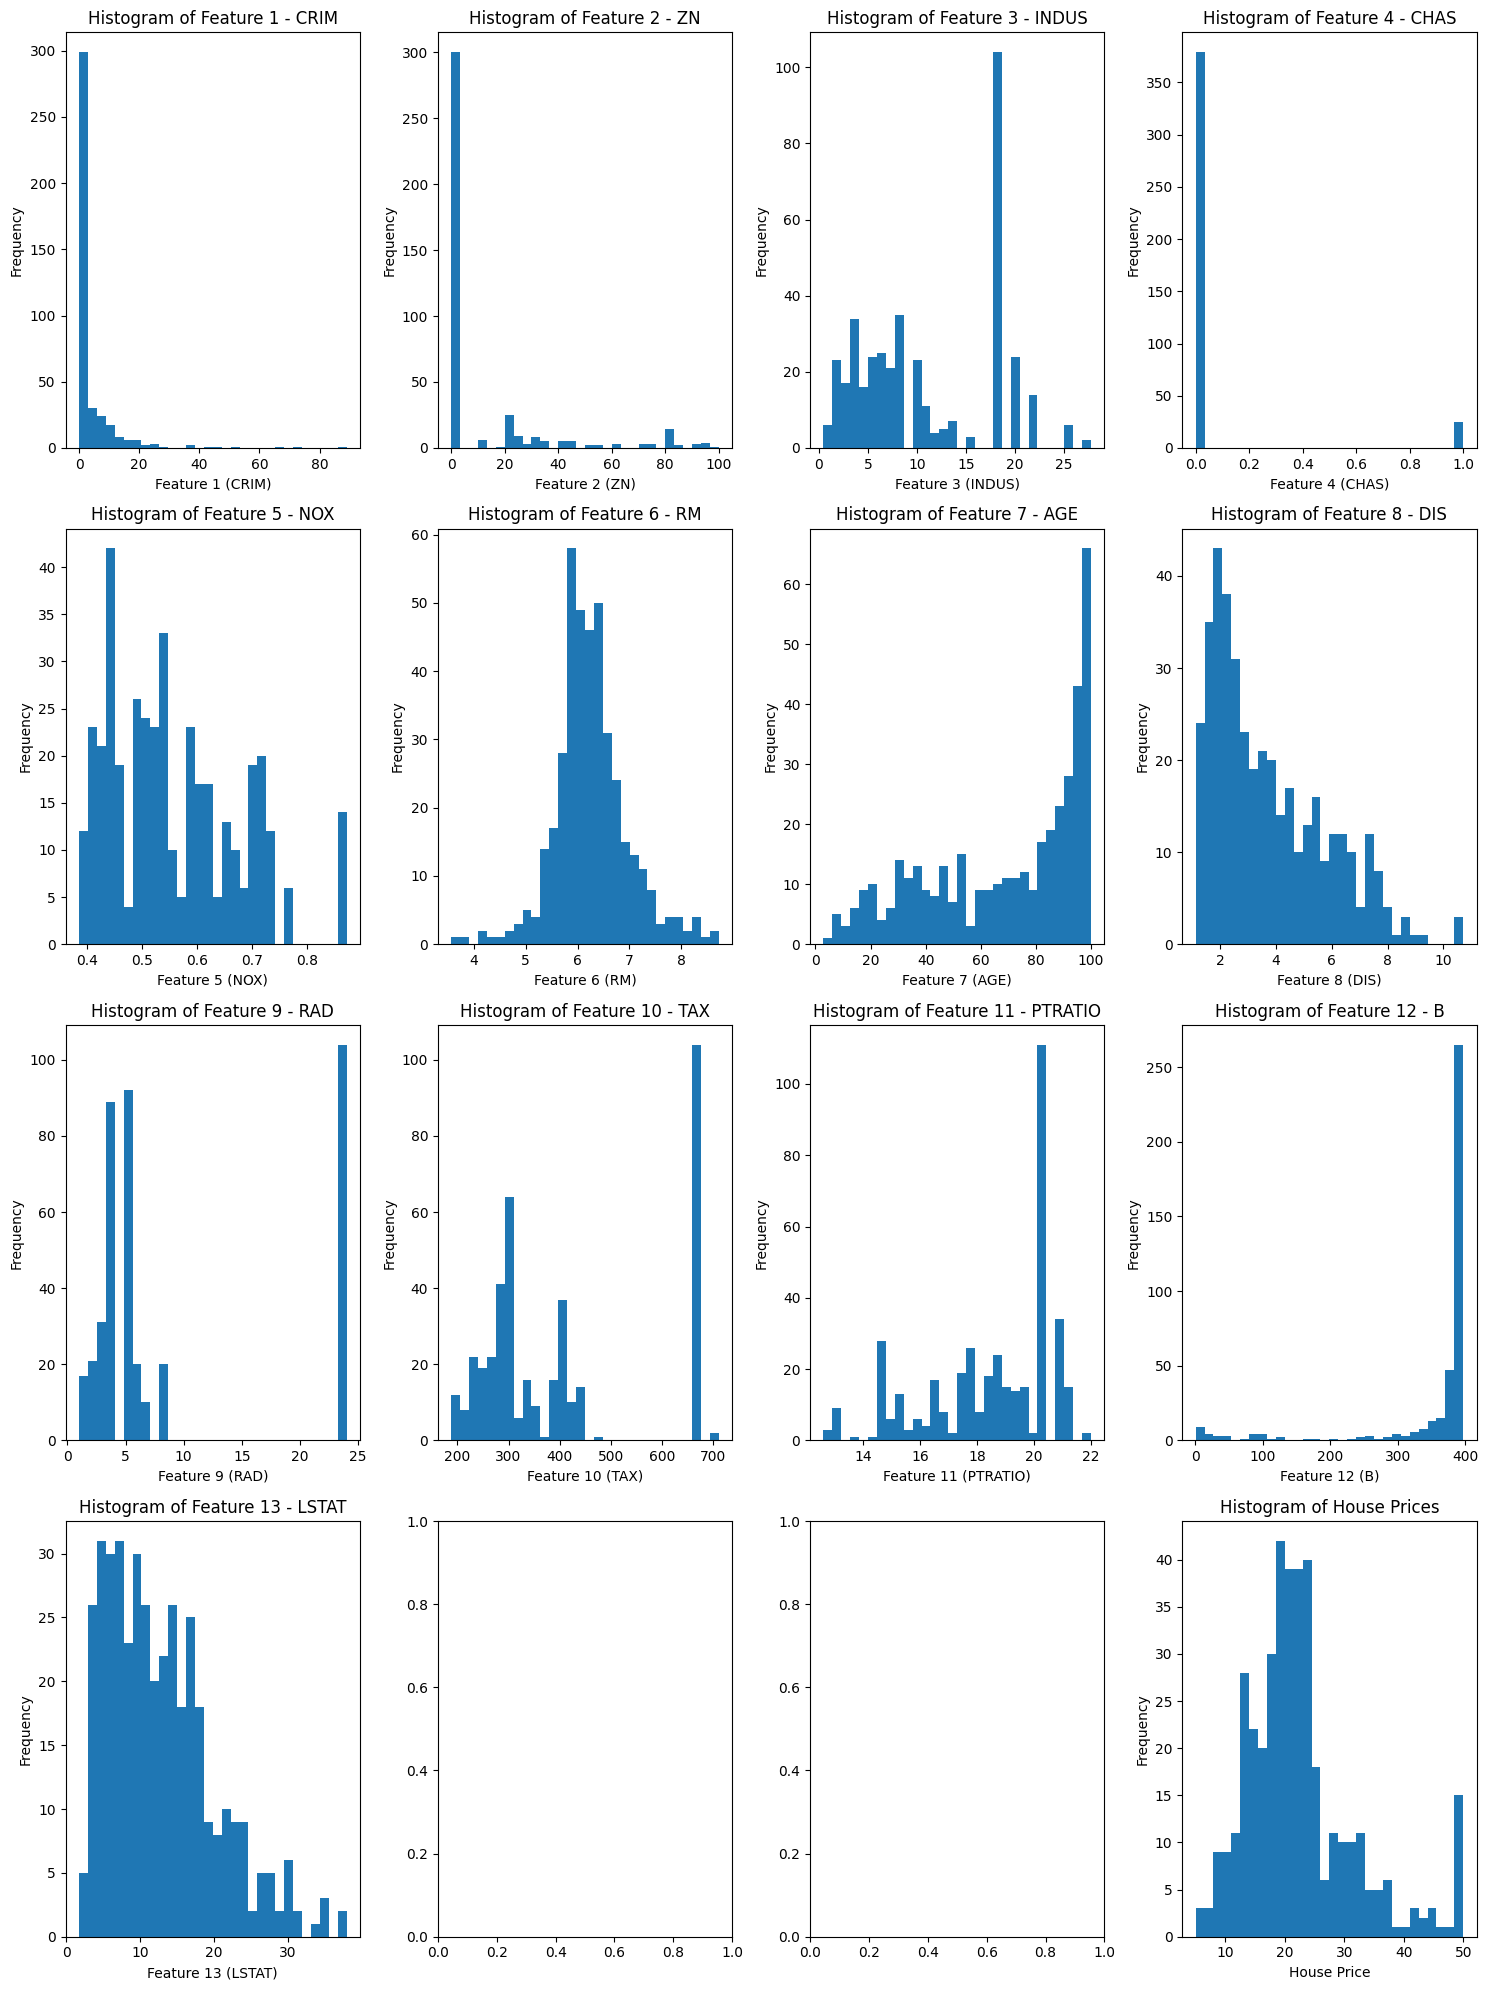

In [17]:
# Histograms of features and price
import matplotlib.pyplot as plt

feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

# Create subplots for histograms
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Plot histograms for each feature
for i in range(num_features):
    axes[i].hist(train_data[:, i], bins=30)
    axes[i].set_xlabel(f"Feature {i+1} ({feature_names[i]})")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Histogram of Feature {i+1} - {feature_names[i]}")

# Plot histogram for house prices
axes[-1].hist(train_labels, bins=30)
axes[-1].set_xlabel("House Price")
axes[-1].set_ylabel("Frequency")
axes[-1].set_title("Histogram of House Prices")


plt.tight_layout()
plt.show()

**Observation:** each feature has different range of values

# Preprocess the data

In [18]:
# 1. Normalize the input and the output data
# standard scaling to center the data around zero and achieve a unit standard deviation

from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
x_train = scaler.fit_transform(train_data)

# Transform the test data using the same scaler
x_test = scaler.transform(test_data)

# Mean and standard deviation after normalization:
print(np.mean(x_train), np.std(x_train), np.mean(x_test), np.std(x_test))

scaler1 = StandardScaler()

# Reshape the labels
y_train_2d = train_labels.reshape(-1, 1)  
y_test_2d = test_labels.reshape(-1, 1)

# Fit the scaler on the training labels and transform it
y_train = scaler1.fit_transform(y_train_2d)

# Transform the test labels using the same scaler
y_test = scaler1.transform(y_test_2d)

# 2. Split the training data into training and validation sets
# The validation set is used to monitor the performance of the model during training and prevent overfitting.

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)



2.6016254395785847e-15 0.9999999999999993 0.020826991430640224 0.9836083446422431


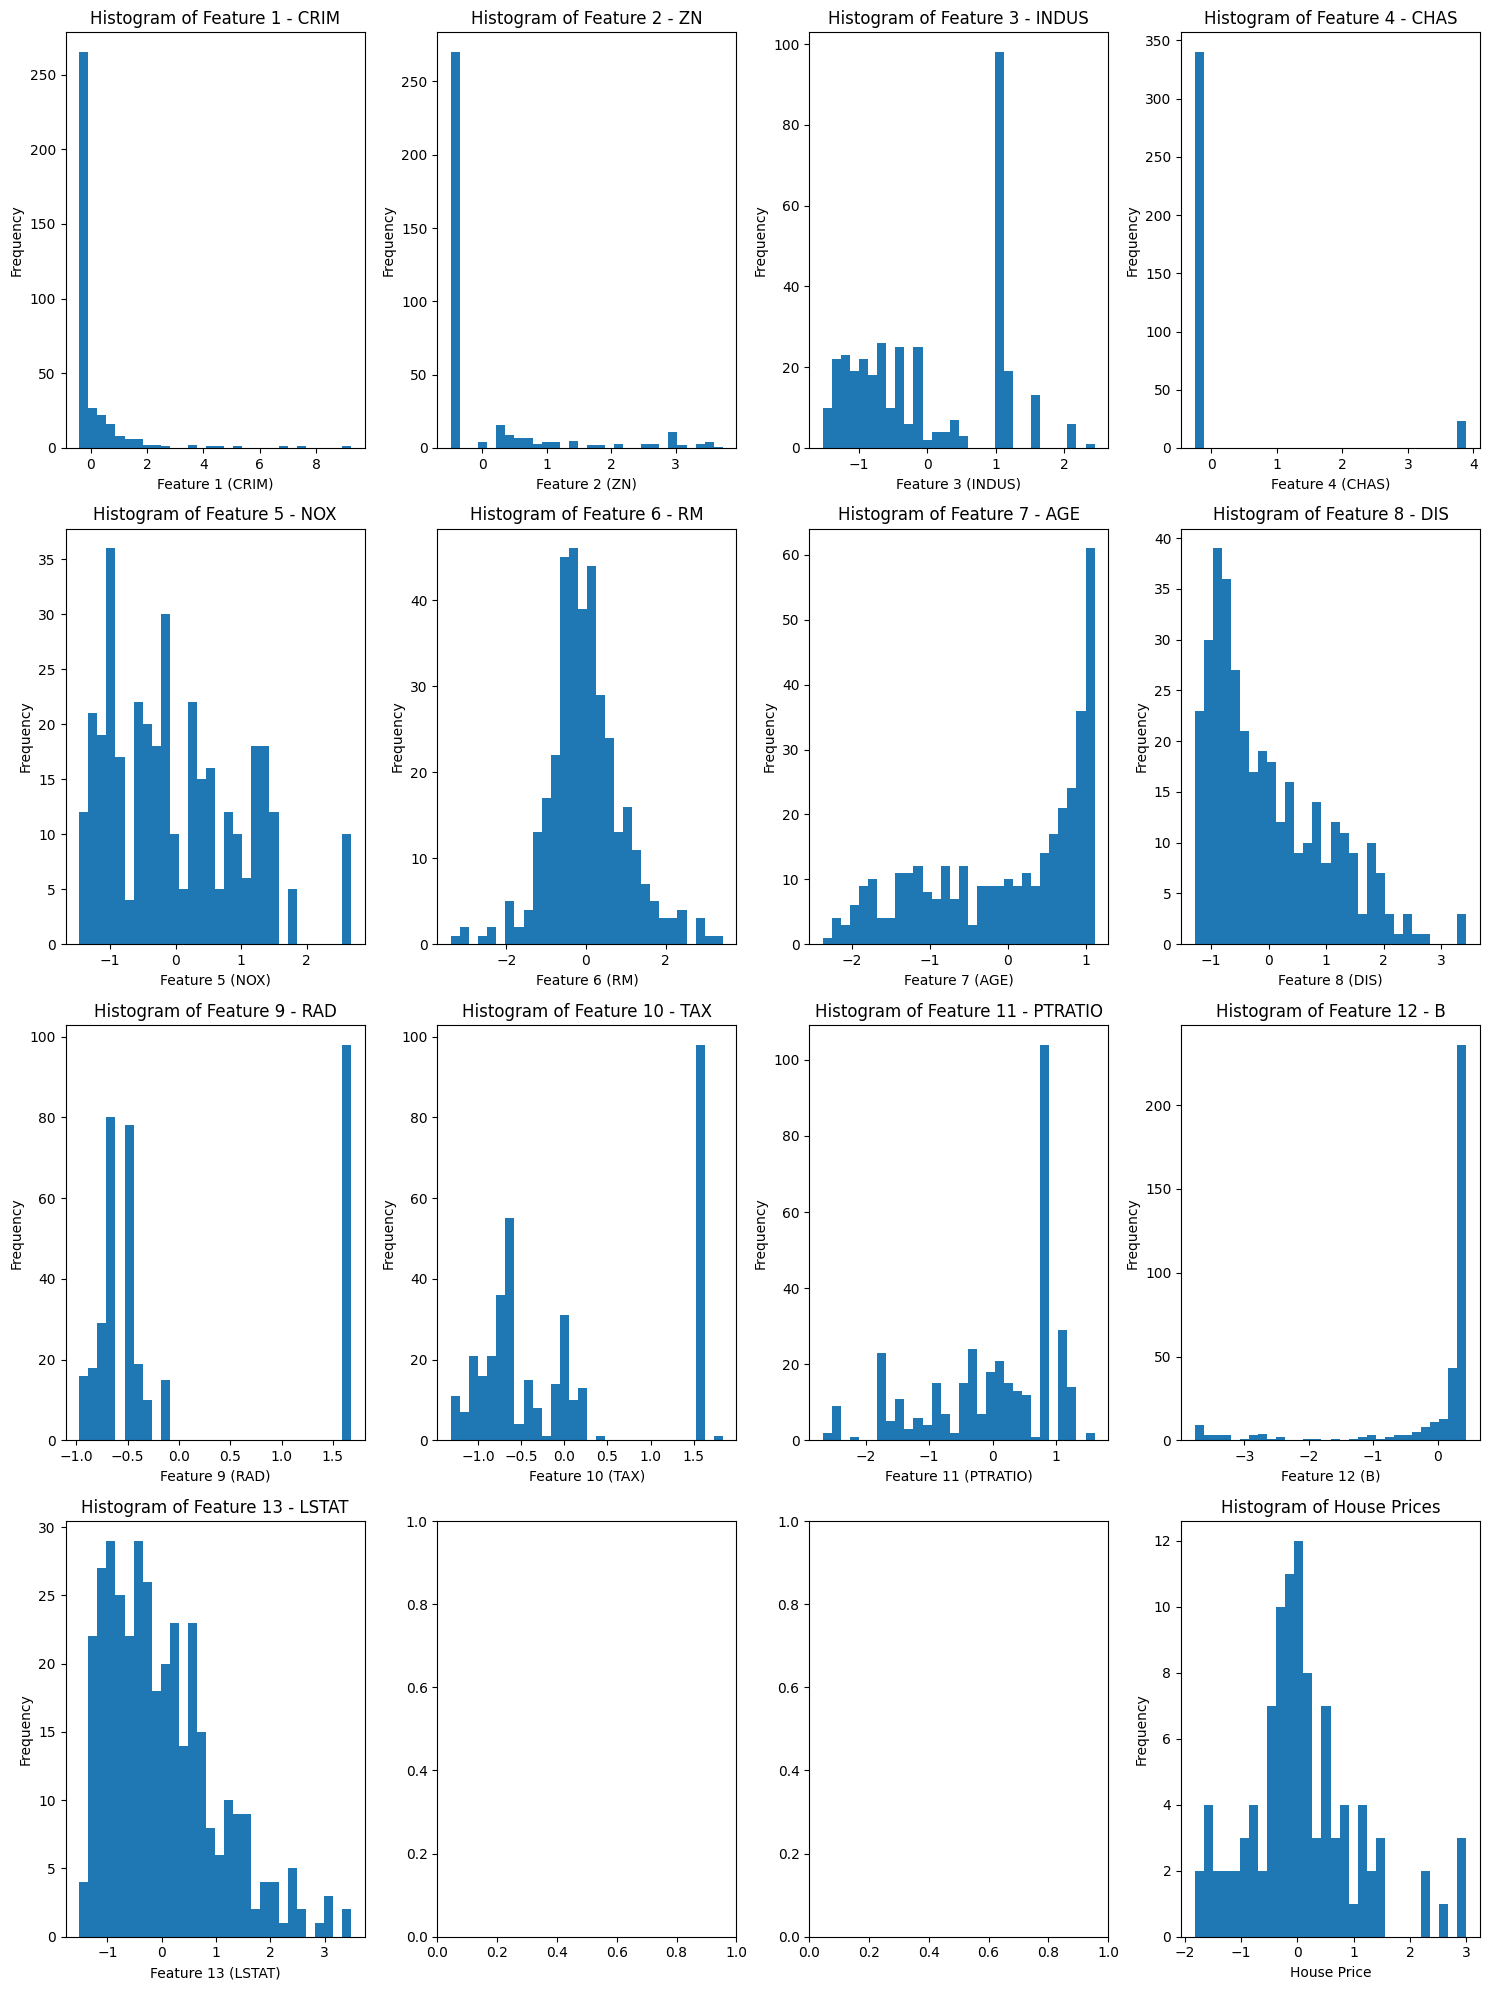

In [19]:
# Histograms of features after normalization
import matplotlib.pyplot as plt
num_features = x_train.shape[1]


feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

# Create subplots for histograms
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Plot histograms for each feature
for i in range(num_features):
    axes[i].hist(x_train[:, i], bins=30)
    axes[i].set_xlabel(f"Feature {i+1} ({feature_names[i]})")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Histogram of Feature {i+1} - {feature_names[i]}")

# Plot histogram for house prices
axes[-1].hist(y_test, bins=30)
axes[-1].set_xlabel("House Price")
axes[-1].set_ylabel("Frequency")
axes[-1].set_title("Histogram of House Prices")


plt.tight_layout()
plt.show()

# K-fold crossvalidation
- the training set is small -> use **k-fold crossvalidation** to find the best parameters of the model 

### MLP model for regression:
- 'linear' activation function in the output layer 
- 'relu' or 'tanh' in the hidden layers
- MSE loss function + MAE or MSE metrics (https://keras.io/api/metrics/regression_metrics/)

Processing fold #0
Processing fold #1
Processing fold #2
Errors: [0.2707488238811493, 0.2986585795879364, 0.23170673847198486]
Mean error: 0.2670380473136902


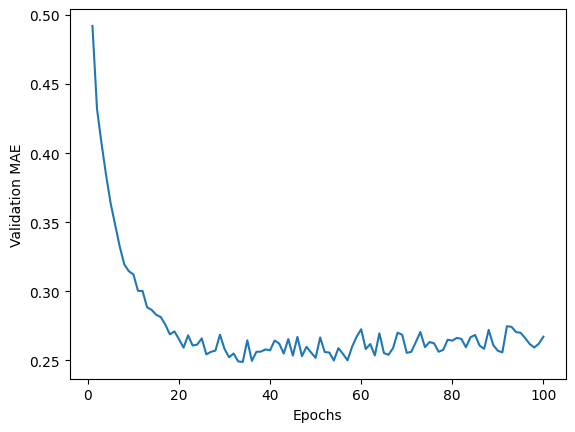

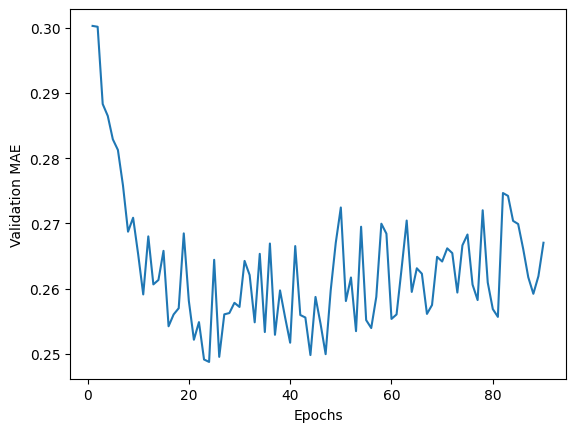

In [20]:
import keras

def build_model():
    model = keras.Sequential([
    keras.layers.InputLayer(shape=(num_features,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')  # output layer
    ])
    model.compile(optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError()])
    return model


# K-fold validation:

k = 3 # 10
num_val_samples = len(x_train) // k
num_epochs = 100
batch_size = 64
all_scores = []
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    x_val = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    y_val = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_x_train, partial_y_train, validation_data=(x_val, y_val),
              epochs=num_epochs, batch_size=batch_size, verbose=0, )
    # print(history.history.keys())
    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)
    val_mse, val_mae = model.evaluate(x_val, y_val, verbose=0)
    all_scores.append(val_mae)

print("Errors:", all_scores)

print("Mean error:", np.mean(all_scores))

# Building the history of successive mean K-fold validation scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# Plotting validation scores
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

# Plotting validation scores, excluding the first 10 data points
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

# Define and train the final model

In [21]:
###############################################
# Define the log directory for Tensorboard
import os
import datetime
import keras

model_datetime_name = "boston_mlp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_boston/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################

# define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(shape=(num_features,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')  # output layer
])

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()])


num_epochs = 300
batch_size = 32

# Train the model
history = model.fit(x_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test set
test_error, test_mse, test_mae = model.evaluate(x_test, y_test)
print('Test error:', test_error, test_mse,  '\nTest MAE:', test_mae)


# Save the model
model_dir = "./models/"

# Ensure the directory exists
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# Create a unique model name using the current date and time
model_name = model_dir + model_datetime_name + ".keras"
# Save the model with the generated name
model.save(model_name)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.7956 - mean_absolute_error: 0.6609 - mean_squared_error: 0.7956 - val_loss: 0.2991 - val_mean_absolute_error: 0.3843 - val_mean_squared_error: 0.2991
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3363 - mean_absolute_error: 0.3900 - mean_squared_error: 0.3363 - val_loss: 0.2235 - val_mean_absolute_error: 0.2897 - val_mean_squared_error: 0.2235
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2448 - mean_absolute_error: 0.3004 - mean_squared_error: 0.2448 - val_loss: 0.1685 - val_mean_absolute_error: 0.2580 - val_mean_squared_error: 0.1685
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.1819 - mean_absolute_error: 0.2788 - mean_squared_error: 0.1819 - val_loss: 0.1418 - val_mean_absolute_error: 0.2422 - val_mean_squared_error: 0.1418
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1636 - mean_absolute_error: 0.2659 - mean_squared_error: 0.1636 - val_loss: 0.1152 - val_m

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])


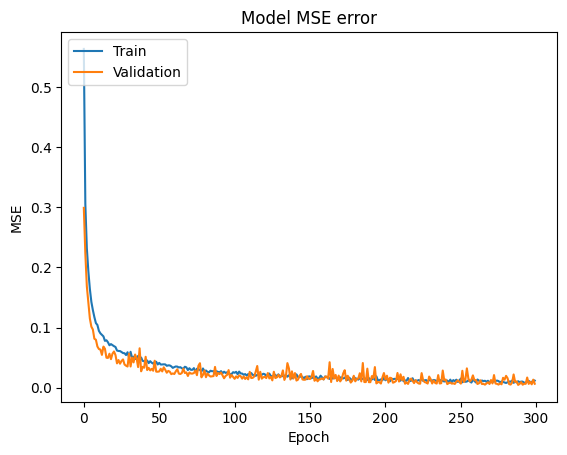

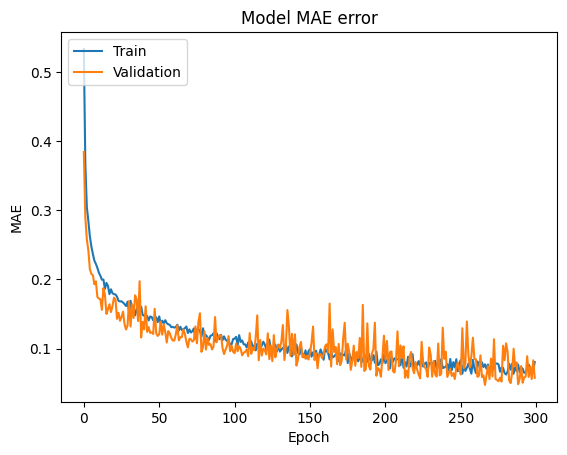

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - mean_absolute_error: 0.0585 - mean_squared_error: 0.0066
Validation MAE: 0.0578078031539917 
Test loss: 0.006635509431362152
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1115 - mean_absolute_error: 0.2313 - mean_squared_error: 0.1115
Test MAE: 0.2560874819755554 
Test loss: 0.1575528383255005


In [22]:
# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())


# Plot training & validation loss values
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model MAE error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Evaluate the model on the validation set
test_loss, _, test_mae = model.evaluate(x_val, y_val)
print('Validation MAE:', test_mae, '\nTest loss:', test_loss)

# Evaluate the model on the test set
test_loss, _, test_mae = model.evaluate(x_test, y_test)
print('Test MAE:', test_mae, '\nTest loss:', test_loss)

## Evaluate the model and make predictions on new data

In [23]:

# Get predicted values
y_pred = model.predict(x_test)

# Convert predicted values:
predicted_labels = scaler1.inverse_transform(y_pred)

# To 1D array
predicted_labels =  np.squeeze(predicted_labels, axis=1)

# Observe some predictions
print(list(zip (np.squeeze(y_test, axis=1)[:5], np.squeeze(y_pred, axis=1)[:5])))
print(list(zip (test_labels[:5], predicted_labels[:5])))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[(-1.6518090001432328, -1.4550105), (-0.39080722483352276, -0.45369962), (-0.3690658149143899, -0.29161555), (0.5005905818509273, 0.20681448), (-0.02120325620826308, -0.01113249)]
[(7.2, 9.010356), (18.8, 18.22145), (19.0, 19.712467), (27.0, 24.297543), (22.2, 22.29264)]


## Summary
1. For regression, the MSE loss function and specific metrics (MSE, MAE, etc.) are used. A linear activation function is chosen for the output layer.
2. If the input features have different value ranges, it's good practice to normalize each one based on the standard deviation.
3. The smaller the training set, the smaller the model we should train to avoid overfitting.
4. If the model is trained for too long, it starts overfitting (the error on the validation set increases).
5. If we have a small amount of data, it's better to use k-fold cross-validation to evaluate the model performance.

# Excersises
1. **Use k-fold crossvalidation** to find optimal number of neurons in the hidden layers. 
2. **Implement early stopping** to avoid overtraining. Compare the results (observe the error on the validation or testing sets and the training currves).
3. **Add L2-regularization, L1-regularization, dropout layers** to avoid overtraining. Compare the results (observe the error on the validation or testing sets and the training currves).
4. **Apply data augmentation** to avoid overtraining. Compare the results (observe the error on the validation or testing sets and the training currves).

In [24]:
# Early stopping:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [25]:
# Regularization:
model1 = keras.Sequential([
    keras.layers.InputLayer(shape=(num_features,)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), 
                       bias_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')  # output layer
    ])


In [26]:
# Dropout layers:
model1 = keras.Sequential([
    keras.layers.InputLayer(shape=(num_features,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),  # Add after each dense layer
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='linear')  # output layer
    ])


In [27]:
# Data augmentation (by adding noise):
def augment_data(X, y, num_copies):
  """
  Performs data augmentation on input and output data.

  Args:
    X: Input data (2D numpy array).
    y: Output data (2D numpy array).
    num_copies: The number of augmented copies to create for each data point.

  Returns:
    Tuple: Augmented input (X_aug) and output (y_aug) data.
  """

  X_aug = []
  y_aug = []

  for i in range(len(X)):
    X_aug.append(X[i])
    y_aug.append(y[i])
    for _ in range(num_copies):
      noise = np.random.normal(0, 0.1, X[i].shape)  # Adjust noise level as needed
      X_aug.append(X[i] + noise)
      y_aug.append(y[i]) # Output remains the same


  return np.array(X_aug), np.array(y_aug)

x_train_augmented, y_train_augmented = augment_data(x_train, y_train, 3)

print(x_train.shape, x_train_augmented.shape)

(363, 13) (1452, 13)


In [28]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_boston --reload_interval=1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 15396), started 3:13:54 ago. (Use '!kill 15396' to kill it.)